In [12]:
import pandas as pd
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

## Discretize the probability density functions of all edges

In [13]:
# Create range [0, T] with T = 4 to discretize our range of time when generating gamma distributions
T = 4
timeUnit = 0.001
intervals = int(T / timeUnit)
x = np.linspace(0, T, intervals + 1)

# Create alpha and scale parameters for each edge
gammaParams = pd.DataFrame(
    columns=['1', '2', '3', '4', '5'],
    index=['1', '2', '3', '4', '5']
)
gammaParams.loc['1', '2'] = gammaParams.loc['2', '1'] = (1, 1)
gammaParams.loc['1', '3'] = gammaParams.loc['3', '1'] = (2, 2)
gammaParams.loc['1', '4'] = gammaParams.loc['4', '1'] = (2, 2)
gammaParams.loc['2', '3'] = gammaParams.loc['3', '2'] = (2, 2)
gammaParams.loc['2', '4'] = gammaParams.loc['4', '2'] = (1, 2)
gammaParams.loc['2', '5'] = gammaParams.loc['5', '2'] = (1, 1)
gammaParams.loc['3', '4'] = gammaParams.loc['4', '3'] = (2, 1)
gammaParams.loc['3', '5'] = gammaParams.loc['5', '3'] = (1, 2)
gammaParams.loc['4', '5'] = gammaParams.loc['5', '4'] = (2, 1)

# Create nodes
nodes = ['1', '2', '3', '4', '5']

# Create start and end node index
startNodeIndex = []
for node in nodes:
    startNodeIndex = np.append(startNodeIndex, np.full(shape=5, fill_value=node))

endNodeIndex = []
for node in nodes:
    endNodeIndex = np.append(endNodeIndex, nodes)

# Create gamma distribution 3D dataframe
gammaDistributions = pd.DataFrame(
    index=[startNodeIndex, endNodeIndex],
    columns=np.arange(0, intervals + 1)
)
gammaDistributions.index.names = ['startNode', 'endNode']

# Generate probability distributions for each edge
for startNode, endNode in gammaDistributions.index:
        
    # Skip if edge does not exist
    if gammaParams.loc[startNode, endNode] is np.nan:
        continue

    # Find alpha and beta parameters for gamma distribution
    alpha, beta = gammaParams.loc[startNode, endNode]
    
    # Create probability distribution for edge by multiplying gamma distribution with time interval
    gammaDist = gamma.pdf(x, alpha, scale=1/beta) * timeUnit
    gammaDistributions.loc[startNode, endNode] = gammaDist

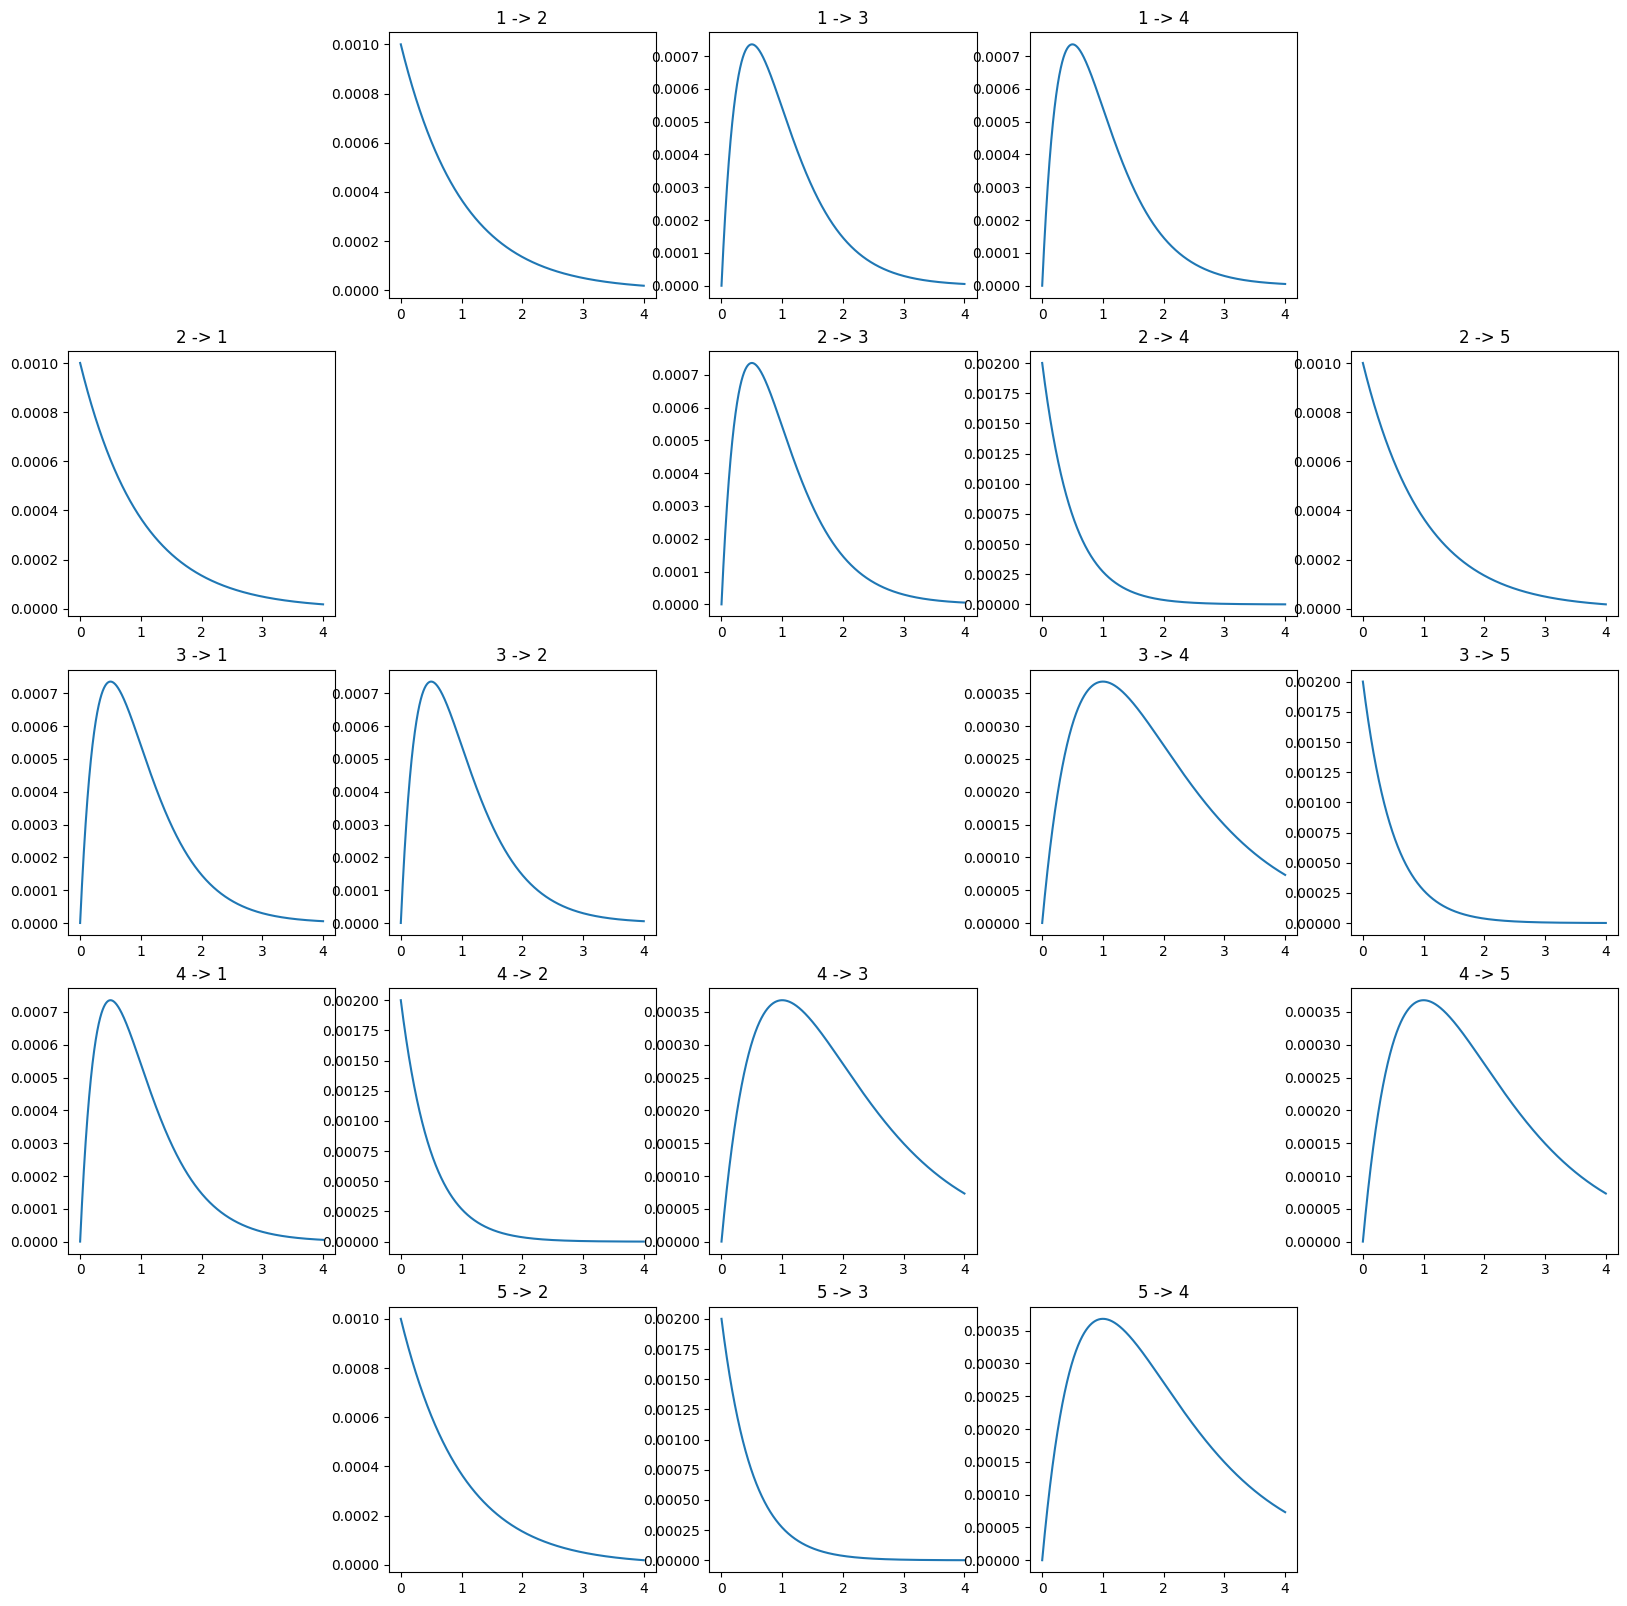

In [14]:
# Plot probability distributions for the heck of it
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, startNode in enumerate(nodes):
    for j, endNode in enumerate(nodes):
        if gammaParams.loc[startNode, endNode] is np.nan:
            axs[i, j].axis('off')
            continue
        axs[i, j].plot(x, gammaDistributions.loc[(startNode, endNode)])
        axs[i, j].set_title(f'{startNode} -> {endNode}')

#### How much of the probability distribution do we cover with T = [0, 4]

In [16]:
for startNode, endNode in gammaDistributions.index:
    if gammaDistributions.loc[startNode, endNode].isna().any():
        print(f'Edge {startNode} -> {endNode} does not exist')
        continue
    else:
        print(f'Edge {startNode} -> {endNode}: ',f'{gammaDistributions.loc[startNode, endNode].sum()}')

Edge 1 -> 1 does not exist
Edge 1 -> 2:  0.9821936007377353
Edge 1 -> 3:  0.9969831859338893
Edge 1 -> 4:  0.9969831859338893
Edge 1 -> 5 does not exist
Edge 2 -> 1:  0.9821936007377353
Edge 2 -> 2 does not exist
Edge 2 -> 3:  0.9969831859338893
Edge 2 -> 4:  1.0006652060562182
Edge 2 -> 5:  0.9821936007377353
Edge 3 -> 1:  0.9969831859338893
Edge 3 -> 2:  0.9969831859338893
Edge 3 -> 3 does not exist
Edge 3 -> 4:  0.908458348921869
Edge 3 -> 5:  1.0006652060562182
Edge 4 -> 1:  0.9969831859338893
Edge 4 -> 2:  1.0006652060562182
Edge 4 -> 3:  0.908458348921869
Edge 4 -> 4 does not exist
Edge 4 -> 5:  0.908458348921869
Edge 5 -> 1 does not exist
Edge 5 -> 2:  0.9821936007377353
Edge 5 -> 3:  1.0006652060562182
Edge 5 -> 4:  0.908458348921869
Edge 5 -> 5 does not exist


## Generate optimal probabilities and optimal policy tables

In [17]:
probabilities = pd.DataFrame(
    columns= np.arange(0, intervals + 1),
    index=['1', '2', '3', '4', '5']
)

probabilities.loc['1', 0] = probabilities.loc['2', 0] = probabilities.loc['3', 0] = probabilities.loc['4', 0] = 0
probabilities.loc['5',] = 1

policy = pd.DataFrame(
    columns= np.arange(0, intervals + 1),
    index=['1', '2', '3', '4', '5']
)

#### Horribly bad non-vectorized operation that took 65 min to iterate on my desktop

In [18]:
# # Iterate through all time budgets
# # for timeBudget in np.arange(0, intervals + 1):
# for timeBudget in np.arange(0, intervals + 1):
#     if timeBudget == 0:
#         continue
    
#     # Iterate through the four possible start nodes
#     for startNode in ['1', '2', '3', '4']:
        
#         # Initialize temporary probabilities for each end node
#         tempProbabilities = pd.Series(data=np.zeros(5), index=['1', '2', '3', '4', '5'])
        
#         # Iterate through all possible end nodes
#         for endNode in ['1', '2', '3', '4', '5']:
            
#             # Only iterate through start and end nodes that are adjacent
#             if gammaDistributions.loc[startNode, endNode] is not np.nan:
                
#                 # Calculate optimal probability of reaching node 5 given the start node, end node, and time budget
#                 for timeUsed in np.arange(timeBudget, 0, -1):
#                     temp = gammaDistributions.loc[startNode, endNode][timeUsed] * probabilities.loc[endNode, timeBudget - timeUsed]
#                     # if startNode == '2':
#                     #     print(f'Time budget: {timeBudget}')
#                     #     print(f'Time used: {timeUsed}')
#                     #     print(f'{startNode}-{endNode}')
#                     #     print(f'Probability: {temp}')
#                     tempProbabilities[endNode] += temp
#                     # if startNode == '2':
#                     #     print(f'{tempProbabilities}')
#                     #     print('\n')
        
#         # Store the optimal probability and optimal policy
#         print(f'Start node: {startNode}')
#         print(f'Time budget: {timeBudget}')
#         print(f'{tempProbabilities}')
#         print(f'{np.argmax(tempProbabilities)}')
#         print('\n')
#         probabilities.loc[startNode, timeBudget] = np.nanmax(tempProbabilities)

#### Significantly better vectorized computation method

In [19]:
# Iterate through all time budgets
for timeBudget in np.arange(1, intervals + 1):
# for timeBudget in np.arange(1, 3):

    # Iterate through the four possible start nodes
    for startNode in ['1', '2', '3', '4']:    
        # Initialize temporary probabilities for each end node
        # nodeProbabilities = pd.Series(data=np.zeros(5), index=['1', '2', '3', '4', '5'])
            
        # Calculate optimal probability of reaching node 5 given the start node, end node, and time budget
        # Find relevant gamma distribution values
        gammaCalc = gammaDistributions.xs(startNode, level='startNode').iloc[:,1:timeBudget+1].copy()
        # Reverse gamma distribution values matrix
        gammaCalc = gammaCalc.iloc[:, ::-1]
        # Find relevant probabilities
        probabilitiesCalc = probabilities.iloc[:,0:timeBudget].copy()
        # Calculate the element-wise product of the two matrices
        result = gammaCalc.values * probabilitiesCalc.values
        row_sums = np.sum(result, axis=1)

        # Store the optimal probability
        probabilities.loc[startNode, timeBudget] = np.nanmax(row_sums)
        
        # Store the optimal policy
        if np.nanmax(row_sums) == 0:
            policy.loc[startNode, timeBudget] = np.nan
        else:
            policy.loc[startNode, timeBudget] = str(np.nanargmax(row_sums)+1)

#### Comparison to paper results

In [20]:
display(probabilities.loc[['1','2'], [20,107,271,524,896,1439,2286,3919]])
display(policy.loc[['1','2'], [20,107,271,524,896,1439,2286,3919]])

,20,107,271,524,896,1439,2286,3919
1,0.000187,0.005279,0.03058,0.097315,0.26697,0.54838,0.833525,0.983413
2,0.019791,0.101424,0.237265,0.407649,0.591505,0.762454,0.897879,0.983413


,20,107,271,524,896,1439,2286,3919
1,2,2,2,2,3,3,3,3
2,5,5,5,5,5,5,5,3


## Simulation